# Pre-procesamiento de datos de EEG con MNE-Python (parte 1)
## Referenciado y filtrado

El presente script está pensado para facilitar el preprocesamiento de datos de EEG con el paquete MNE en python. En esta primera parte se trabajará la referenciación y filtrado de los datos.

## 0. Cargar paquetes

El paso cero es la carga de los paquetes. Es decir, la carga de las distintas funciones que vamos a estar utilizando en el script.

In [1]:
import mne
from copy import deepcopy

## 1. Carga de datos

Posteriormente, cargamos los datos *crudos*. Es decir, los datos tal cual fueron grabados por el Biosemi. Estos datos se encuentran en formato ".bdf".

### 1.1. Carga

Primero, colocamos el código del sujeto dentro de un objeto llamado *subject_id*. De esta forma, nos ahorramos tener cambiar el código del sujeto en todo el código <br>
Luego, colocamos el código de la tarea dentro de un objeto llamado *task*.<br>
Finalmente, dentro de la función  `mne.io.read()`vamos a escribir la ruta al archivo dentro de la computadora. Cargaremos estos datos en un objeto llamado **raw**

In [2]:
subject_id = "SAAV0009"
task = "TOL"

raw = mne.io.read_raw_bdf(("../data/" + task + "/" + "raw/" + subject_id + "_" + task +".bdf"), preload=True)

Extracting EDF parameters from e:\Procesamiento EEG\data\TOL\raw\SAAV0009_TOL.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 736255  =      0.000 ...   718.999 secs...


### 1.1. Inspección 

La función `print()` nos permite ver alguna información muy simple de nuestros datos. 

Aplicándola al objeto **raw** podemos ver que efectivamente guardó un objeto a partir del archivo "SAAV0009_RESTA.bdf" y que ese objeto consta de 73 filas y 313344 columnas. Las filas representan a los canales y las columnas a cada punto en el tiempo. En total contabilizamos 306 segundos.

Aplicándola al objeto **raw.info** (que está adentro de **raw**), podemos ver alguna información de metadata de los datos (e.g. el nombre de los canales).

In [3]:
print(raw)
print(raw.info)

<RawEDF | SAAV0009_TOL.bdf, 73 x 736256 (719.0 s), ~410.1 MB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 72 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 208.0 Hz
 meas_date: 2023-11-13 11:51:57 UTC
 nchan: 73
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 1 item (dict)
>


Eliminaremos los canales que no hayamos usado. En este caso, EXG8.

In [4]:
raw.info['bads'].append('EXG8') 

También vamos a hacer una primera inspección de la señal para ver si hay algún canal en particular que tenga problemas. Si encontramos algo de esto, lo informamos en el documento correspondiente: **AGREGAR LINK**

In [5]:
raw.plot()

Using qt as 2D backend.


## 2. Referenciar los datos

En este momento buscaremos referenciar los datos respecto de las referencias en los mastoides y también respecto al lugar que ocupa cada electrodo en la cabeza.

Para referenciar la señal a los mastoides utilizaremos el método `set_eeg_reference()`. Este método se encuentra dentro de **raw** por lo que deberemos llamarlo escribiendo primero el nombre del objeto a modificar seguido por el método a utilizar: `raw.set_eeg_reference()`. Dentro de esta función excribiremos el nombre de los canales ubicados en los mastoides (en este caso EXG1 y EXG2).

Finalmente, guardaremos los datos referenciados dentro del mismo objeto llamado **raw**. Es decir, lo sobreescribimos.

In [6]:
raw = raw.set_eeg_reference(ref_channels=['EXG1', 'EXG2'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


## 3. Montaje

En el montaje lo que hacemos es darle una ubicación a cada electrodo. Para eso utilizaremos una plantilla que ya viene instalada en MNE. Sin embargo, para que la plantilla funcione, debemos asegurarnos que cada electrodo sea reconocido de forma correcta con sus nombres y clases correctas.

### 3.1. Clasificar a los electrodos externos

En primer lugar clasificaremos a los electrodos externos utilizados en los mastoides como electrodos miscelaneos. Ya que ya los usamos para referenciar y no los volveremos a utilizar. Creamos un objeto llamado misc_ch_names que contiene el nombre de estos electrodos. Luego, mediante `set_channel_types()`le decimos que considere a los canales (electrodos) seleccionados como canales de tipo "misc".

In [7]:
misc_ch_names = ['EXG1', 'EXG2']

raw.set_channel_types({ch_name : "misc" for ch_name in misc_ch_names})

C:\Users\Fede\AppData\Local\Temp\ipykernel_11988\3614300075.py:3: RuntimeWarning: The unit for channel(s) EXG1, EXG2 has changed from V to NA.
  raw.set_channel_types({ch_name : "misc" for ch_name in misc_ch_names})


<RawEDF | SAAV0009_TOL.bdf, 73 x 736256 (719.0 s), ~410.1 MB, data loaded>

A los electrodos EXG3, EXG4 y EXG5 que los utilizamos para ver movimientos oculares los clasificaremos como "eog" que viene de "electro-oculography". Usaremos el mismo método que con los otros electrodos externos.

In [8]:
eog_ch_names = ['EXG3', 'EXG4', 'EXG5']

raw.set_channel_types({ch_name : "eog" for ch_name in eog_ch_names})

<RawEDF | SAAV0009_TOL.bdf, 73 x 736256 (719.0 s), ~410.1 MB, data loaded>

A los electrodos EXG6, EXG7 que los utilizamos para ver actividad caríaca los clasificaremos como "ecg" que viene de "electro-cardioagraphy".

In [9]:
ecg_ch_names = ['EXG6', 'EXG7']

raw.set_channel_types({ch_name : "ecg" for ch_name in ecg_ch_names})

<RawEDF | SAAV0009_TOL.bdf, 73 x 736256 (719.0 s), ~410.1 MB, data loaded>

### 3.2. Cambiar nombre de electrodos eeg

Cuando Biosemi almacena la información de los electrodos lo hace con otro nombre. Nosotros lo traduciremos a la forma más común de nombrarlos (y la que usa MNE). Para eso, creamos un objeto que se llama channel_dict y que vendría a ser un diccionario sobre como se llama cada canal.

In [10]:

channel_dict = {'A1' : 'Fp1',
                     'A2' : 'AF7',
                     'A3' : 'AF3',
                     'A4' : 'F1',
                     'A5' : 'F3',
                     'A6' : 'F5',
                     'A7' : 'F7',
                     'A8' : 'FT7',
                     'A9' : 'FC5',
                     'A10' : 'FC3',
                     'A11' : 'FC1',
                     'A12' : 'C1',
                     'A13' : 'C3',
                     'A14' : 'C5',
                     'A15' : 'T7',
                     'A16' : 'TP7',
                     'A17' : 'CP5',
                     'A18' : 'CP3',
                     'A19' : 'CP1',
                     'A20' : 'P1',
                     'A21' : 'P3',
                     'A22' : 'P5',
                     'A23' : 'P7',
                     'A24' : 'P9',
                     'A25' : 'PO7',
                     'A26' : 'PO3',
                     'A27' : 'O1',
                     'A28' : 'Iz',
                     'A29' : 'Oz',
                     'A30' : 'POz',
                     'A31' : 'Pz',
                     'A32' : 'CPz',
                     
                     'B1'  : 'Fpz',
                     'B2'  : 'Fp2',
                     'B3'  : 'AF8',
                     'B4'  : 'AF4',
                     'B5'  : 'AFz',
                     'B6'  : 'Fz',
                     'B7'  : 'F2',
                     'B8'  : 'F4',
                     'B9'  : 'F6',
                     'B10' : 'F8',
                     'B11' : 'FT8',
                     'B12' : 'FC6',
                     'B13' : 'FC4',
                     'B14' : 'FC2',
                     'B15' : 'FCz',
                     'B16' : 'Cz',
                     'B17' : 'C2',
                     'B18' : 'C4',
                     'B19' : 'C6',
                     'B20' : 'T8',
                     'B21' : 'TP8',
                     'B22' : 'CP6',
                     'B23' : 'CP4',
                     'B24' : 'CP2',
                     'B25' : 'P2',
                     'B26' : 'P4',
                     'B27' : 'P6',
                     'B28' : 'P8',
                     'B29' : 'P10',
                     'B30' : 'PO8',
                     'B31' : 'PO4',
                     'B32' : 'O2'}




Ese diccionario lo pasaremos dentro de la función `rename_channels()`justamente para renombrar a cada canal. Sobreescribiremos los datos dentro de raw.

In [11]:

raw = raw.rename_channels(channel_dict)   



Luego, volveremos a sobreescribir a raw para pasarle la información de dónde está ubicado cada canal. Lo haremos mediante `set_montage("biosemi64")`.

In [12]:
raw = raw.set_montage("biosemi64", on_missing="ignore")

# 4. Guardar datos referenciados

In [13]:
raw.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF.fif"), overwrite=True)



Overwriting existing file.
Writing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF.fif


C:\Users\Fede\AppData\Local\Temp\ipykernel_11988\1027183679.py:1: RuntimeWarning: This filename (e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF.fif"), overwrite=True)


Closing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF.fif
[done]


## 4. Filtrado

Con el proceso de filtrado recortamos la amplitud de la señal para quedarnos sólo con la amplitud que nos interesa (de 0.5 a 40)

### 4.1. Realizar el filtrado

In [14]:
raw_filtered = raw.filter(l_freq=0.5, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


### 4.2. Power spectral density plot (PSD)

El gráfico PSD nos permite ver la distribución de las frecuencias luego del filtrado.

Effective window size : 2.000 (s)


c:\Users\Fede\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


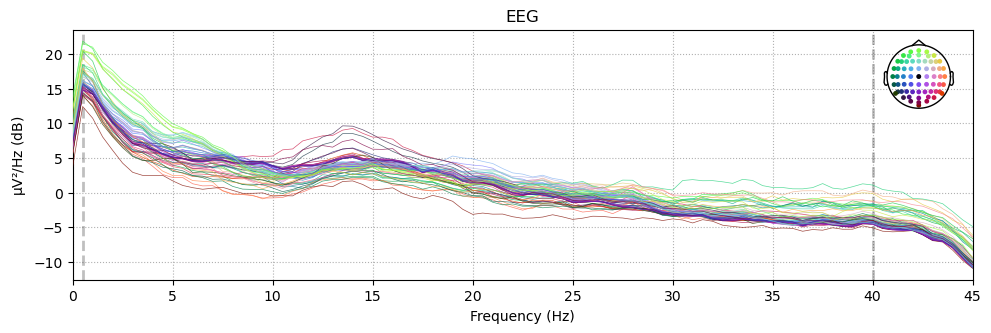

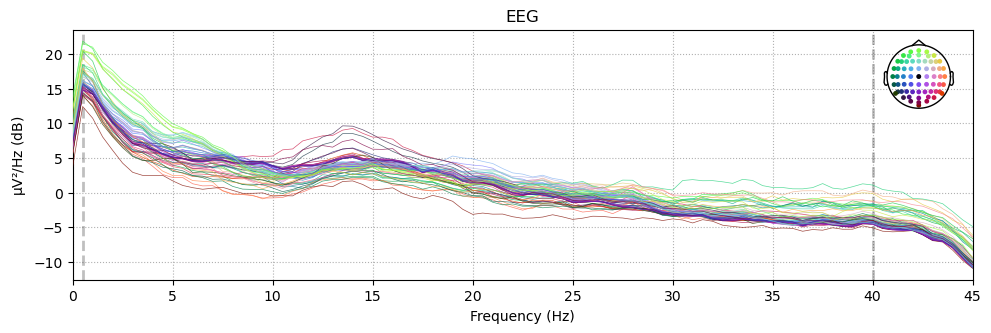

In [15]:
raw_filtered.compute_psd(fmax=45).plot(picks="eeg")

## 5. Guardar datos filtrados

In [16]:
raw_filtered.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT.fif"), overwrite=True)

Overwriting existing file.
Writing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF_FILT.fif


C:\Users\Fede\AppData\Local\Temp\ipykernel_11988\1793239165.py:1: RuntimeWarning: This filename (e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF_FILT.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT.fif"), overwrite=True)


Closing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF_FILT.fif
[done]


Channels marked as bad:
none
